In [1]:
import os
import datetime
import cftime

import netCDF4 as nc4

import pyart
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib import colors

import re

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/users/cjwalden/anaconda3/envs/pyart_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
def read_cobalt_cmd_file(file_path):
    with open(file_path, "r") as file:
        line = file.readline()
        newline = line.rstrip().replace(': ', ':') 
        pairs = newline.split()
        data = {}

        for pair in pairs:
            key, value = pair.split(':')
            data[key.strip()] = value.strip()
    return data

def extract_azimuth_from_file(file_path):  
    # Implement a way to extract the azimuth from the file.  
    # This is a placeholder; adjust according to your file's format.  
    data = read_cobalt_cmd_file(file_path)  
    return float(data.get('azimuth', 0))  # Assuming azimuth is stored under the key 'azimuth'  

def find_nearest_file(directory, netcdf_time, target_azimuth):  
    nearest_file = None  
    nearest_file_time = None  
    nearest_azimuth_diff = float('inf')  
    candidates = []  

    # First pass: find files with the closest azimuth  
    for file_name in os.listdir(directory):  
        match = log_file_pattern.match(file_name)  
        if match:  
            # Extract date and time from the file name  
            date_part = match.group(1)  
            time_part = match.group(2)  
            file_time_str = f"{date_part}{time_part}"  
            file_time = datetime.datetime.strptime(file_time_str, "%Y%m%d%H%M%S")  

            # Calculate time difference  
            time_diff = abs(netcdf_time - file_time)  

            # Only consider files with a time difference of less than 600 seconds  
            if time_diff < datetime.timedelta(seconds=600):  
                # Extract azimuth from the file  
                azimuth = extract_azimuth_from_file(os.path.join(directory, file_name))  
                azimuth_diff = abs(target_azimuth - azimuth)  

                # If this file's azimuth is closer, reset candidates  
                if azimuth_diff < nearest_azimuth_diff:  
                    nearest_azimuth_diff = azimuth_diff  
                    candidates = [(file_name, file_time, time_diff)]  
                elif azimuth_diff == nearest_azimuth_diff:  
                    candidates.append((file_name, file_time, time_diff))  

    # Second pass: among candidates, find the one with the closest time  
    nearest_time_diff = datetime.timedelta.max  

    for file_name, file_time, time_diff in candidates:  
        if time_diff < nearest_time_diff:  
            nearest_file = file_name  
            nearest_file_time = file_time  
            nearest_time_diff = time_diff  

    return nearest_file, nearest_file_time  # Return both the file name and file time  

def get_time_coverage_start(netcdf_file_path):
    try:
        # Open the NetCDF file
        with nc4.Dataset(netcdf_file_path, 'r') as DS:
            # Extract the global attribute 'time_coverage_start'
            if 'time_coverage_start' in DS.ncattrs():
                time_coverage_start = DS.getncattr('time_coverage_start')
                return time_coverage_start
            else:
                raise ValueError("Attribute 'time_coverage_start' not found in the NetCDF file.")
    except Exception as e:
        print(f"Error reading NetCDF file: {e}")
        return None

def great_circle_distance(earth_radius, target_range, zenith_angle):

    target_altitude = get_target_altitude(earth_radius, target_range, zenith_angle)

    # Calculate the angular distance in radians
    delta = np.arcsin(target_range*np.sin(zenith_angle)/(earth_radius+target_altitude))

    # Convert angular distance to great-circle distance in meters
    great_circle_dist = earth_radius * delta

    return great_circle_dist

def get_target_altitude(earth_radius, target_range, zenith_angle):
    """
    Calculate the altitude of the radar target above the Earth's surface.

    Parameters:
        earth_radius (float): Radius of the Earth.
        target_range (float): Range to the radar target.
        zenith_angle (float): Angle between the local zenith and the target in radians.

    Returns:
        float: Altitude of the target.
    """
    # Use the law of cosines to calculate the distance from Earth's center to the target
    r_t = np.sqrt(
        earth_radius**2 + target_range**2 + 2 * earth_radius * target_range * np.cos(zenith_angle)
    )

    # Altitude is the distance from Earth's surface to the target
    altitude = np.abs(r_t - earth_radius)

    return altitude

In [3]:
def make_cobalt_rhi_plot(ncfile,sweep=0,xlim=[0,40],hmax=14):

    # Get the time_coverage_start
    time_coverage_start = get_time_coverage_start(ncfile);
    netcdf_time = datetime.datetime.strptime(time_coverage_start, "%Y-%m-%dT%H:%M:%SZ")

    DS = nc4.Dataset(ncfile);
    scan_azimuth = DS['fixed_angle'][0];
    DS.close();

    print(f"scan_azimuth = {scan_azimuth}")

    # Find the nearest command file
    nearest_file, logfile_time = find_nearest_file(cobalt_cmd_path, netcdf_time, scan_azimuth)

    logfile_time_str = datetime.datetime.strftime(logfile_time,'%Y-%m-%dT%H:%M:%SZ')

    if nearest_file:
        print(f"The nearest file is: {nearest_file}")
    else:
        print("No matching files found.")

    cmd_data = read_cobalt_cmd_file(os.path.join(cobalt_cmd_path,nearest_file));

    print(cmd_data);

    hmax = hmax;
    xmin = xlim[0];
    xmax = xlim[1];
    
    dbz_cmap = 'pyart_HomeyerRainbow';
    vel_cmap = 'pyart_balance';
    ldr_cmap = 'viridis';
    spw_cmap = 'pyart_SpectralExtended';

    DS = nc4.Dataset(ncfile);
    product_version = DS.product_version;
    DS.close();

    RadarDS = pyart.io.read_cfradial(ncfile);

    dtime0 = cftime.num2pydate(RadarDS.time['data'][0],RadarDS.time['units']);
    dtime0_str = dtime0.strftime("%Y%m%d-%H%M%S");
    nsweeps = RadarDS.nsweeps;

    if nsweeps==1:
        sweep = 0

    vel_field = RadarDS.fields['VEL']
    vel_limit_lower = vel_field['field_limit_lower']
    vel_limit_upper = vel_field['field_limit_upper']

    gatefilter = pyart.correct.GateFilter(RadarDS)
    #gatefilter.exclude_below('SNR', -20)

    #pyart.correct.despeckle_field(RadarDS, "SNR", size=3, threshold=-20, gatefilter=gatefilter, delta=5.0)

    display = pyart.graph.RadarDisplay(RadarDS);

    fig, ax = plt.subplots(2,2,figsize=(14,8),constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=1 / 72, h_pad=1 / 72, hspace=0.2,wspace=0.2)
    display.plot_rhi("DBZ", ax=ax[0,0], sweep=sweep, vmin=-40, vmax=40, 
                    norm=None, cmap=dbz_cmap, colorbar_orient='horizontal')
    ax[0,0].set_ylim(0,hmax)
    ax[0,0].set_xlim(xmin,xmax)
    ax[0,0].grid(True)
    ax[0,0].set_aspect('equal','box');
    display.plot_rhi("VEL", ax=ax[1,0], sweep=sweep, vmin=vel_limit_lower, vmax=vel_limit_upper,  gatefilter=gatefilter,
                    norm=None, cmap=vel_cmap, colorbar_orient='horizontal',filter_transitions=True)
    ax[1,0].set_ylim(0,hmax)
    ax[1,0].set_xlim(xmin,xmax)
    ax[1,0].grid(True)
    ax[1,0].set_aspect('equal','box');
    display.plot_rhi("WIDTH", ax=ax[0,1], sweep=0, gatefilter=gatefilter,
                    norm=colors.LogNorm(vmin=1e-1*np.sqrt(1e-1),vmax=np.sqrt(1e1)), 
                    cmap=spw_cmap, colorbar_orient='horizontal',filter_transitions=True)
    ax[0,1].set_ylim(0,hmax)
    ax[0,1].set_xlim(xmin,xmax)
    ax[0,1].grid(True)
    ax[0,1].set_aspect('equal','box'); 
    display.plot_rhi("LDR", ax=ax[1,1], sweep=0,vmin=-35, vmax=5, norm=None, gatefilter=gatefilter,
                    cmap=ldr_cmap, colorbar_orient='horizontal',filter_transitions=True)
    ax[1,1].set_ylim(0,hmax)
    ax[1,1].set_xlim(xmin,xmax)
    ax[1,1].grid(True)
    ax[1,1].set_aspect('equal','box');

    orig_title = ax[0,0].get_title();
    title_lines = orig_title.split("\n");

    target_range = float(cmd_data['range'])/1000.0;
    target_elev = np.deg2rad(float(cmd_data['elevation']));

    target_height = target_range * np.sin(target_elev);
    target_zenith_angle = np.pi/2.0-target_elev;

    print(f'Target zenith angle = {90-np.rad2deg(target_elev)}')

    target_horiz_dist = target_range * np.cos(target_elev);
    target_height = target_range * np.sin(target_elev);

    target_arc_dist = great_circle_distance(6371.0, target_range, target_zenith_angle)
    target_altitude = get_target_altitude(6371.0, target_range, np.pi-target_zenith_angle)

    print(f'Target arc dist = {target_arc_dist}');
    print(f'Target altitude = {target_altitude}');
    print(f'Target horiz dist = {target_horiz_dist}');
    print(f'Target height = {target_height}')

    ax[0,0].plot(target_arc_dist, target_altitude, 'k+')  
    ax[1,0].plot(target_arc_dist, target_altitude, 'k+')  
    ax[0,1].plot(target_arc_dist, target_altitude, 'k+')  
    ax[1,1].plot(target_arc_dist, target_altitude, 'k+')  

    ax[0,0].plot(target_horiz_dist, target_height, 'b+')  
    ax[1,0].plot(target_horiz_dist, target_height, 'b+')  
    ax[0,1].plot(target_horiz_dist, target_height, 'b+')  
    ax[1,1].plot(target_horiz_dist, target_height, 'b+')  


    target_str = f"{logfile_time_str} {cmd_data['flight_id']} {cmd_data['icao_id']} {cmd_data['aircraft_type']} lean_burn={cmd_data['lean_burn']} Az={float(cmd_data['azimuth']):.1f} El={float(cmd_data['elevation']):.1f}"
    if 'advected' in cmd_data:
        target_str += f" advected {cmd_data['advected']}"

    title_lines[1] = target_str;
    new_title = "\n".join(title_lines)  # Rejoin the lines

    ax[0,0].set_title("",fontsize=8)
    ax[1,0].set_title("",fontsize=8)
    ax[0,1].set_title("",fontsize=8)
    ax[1,1].set_title("",fontsize=8)

    fig.suptitle(new_title, fontsize=11)  

In [4]:
def find_sweeps_in_time_range(file_path, start_time, end_time):
    """
    Find sweeps in a CF-Radial file between a given start and end time.

    Parameters:
        file_path (str): Path to the CF-Radial file.
        start_time (datetime.datetime): Start of the time range.
        end_time (datetime.datetime): End of the time range.

    Returns:
        list: List of sweep indices within the time range.
    """
    # Read the radar file
    radar = pyart.io.read(file_path)

    # Get the base time (epoch start) from the radar file
    base_time_str = radar.time['units']  # Example: 'seconds since 1970-01-01T00:00:00Z'
    base_time = datetime.datetime.strptime(base_time_str.split("since")[1].strip(), "%Y-%m-%dT%H:%M:%SZ")

    # Get sweep start/end times
    sweep_times = []
    for sweep in range(radar.nsweeps):
        start_idx = radar.sweep_start_ray_index['data'][sweep]
        end_idx = radar.sweep_end_ray_index['data'][sweep]

        # Time of the first ray in the sweep
        start_offset = radar.time['data'][start_idx]
        start_time_sweep = base_time + datetime.timedelta(seconds=float(start_offset))

        # Time of the last ray in the sweep
        end_offset = radar.time['data'][end_idx]
        end_time_sweep = base_time + datetime.timedelta(seconds=float(end_offset))

        sweep_times.append((start_time_sweep, end_time_sweep))

    # Find sweeps within the given time range
    valid_sweeps = [
        idx for idx, (sweep_start, sweep_end) in enumerate(sweep_times)
        if sweep_start <= end_time and sweep_end >= start_time
    ]

    return valid_sweeps

def make_cobalt_vpt_plot(datestr,inpath,start_time,end_time):

    start_time = datetime.datetime.strptime(f"{datestr}T{start_time}","%Y%m%dT%H:%M");
    end_time = datetime.datetime.strptime(f"{datestr}T{end_time}","%Y%m%dT%H:%M");

    hmax = 14;

    dbz_cmap = 'pyart_HomeyerRainbow';
    vel_cmap = 'pyart_balance';
    ldr_cmap = 'viridis';
    spw_cmap = 'pyart_SpectralExtended';

    current_date = datetime.datetime.strptime(datestr, '%Y%m%d');
    prev_date = current_date - datetime.timedelta(days=1);
    prevstr = prev_date.strftime('%Y%m%d');

    inpath_date = os.path.join(inpath,datestr);
    
    os.chdir(inpath_date);
    vpt_file = [os.path.join(inpath_date,f) for f in glob.glob('*{}*vpt*.nc'.format(datestr))][0]

    sweeps = find_sweeps_in_time_range(vpt_file, start_time, end_time)
    print(f"Sweeps within the time range: {sweeps}")
    nsweeps = len(sweeps);


    DS = nc4.Dataset(vpt_file);
    product_version = DS.product_version;
    print(f'product version = {product_version}')
    DS.close();

    RadarDS_VPT = pyart.io.read_cfradial(vpt_file);
    
    vel_field = RadarDS_VPT.fields['VEL']
    vel_limit_lower = vel_field['field_limit_lower']
    vel_limit_upper = vel_field['field_limit_upper']

    
    fig, ax = plt.subplots(4,1,figsize=(12,18),constrained_layout=True)
    fig.set_constrained_layout_pads(w_pad=1 / 72, h_pad=1 / 72, hspace=0.2,wspace=0.2)

    #pyart.correct.despeckle_field(RadarDS, "SNR", size=3, threshold=-20, gatefilter=gatefilter, delta=5.0)

    s = sweeps[0];
    RadarSweepDS = RadarDS_VPT.extract_sweeps([s])
    gatefilter = pyart.correct.GateFilter(RadarSweepDS)
    gatefilter.exclude_below('SNR', -20)
    display = pyart.graph.RadarDisplay(RadarSweepDS);

    dtime = cftime.num2pydate(RadarDS_VPT.time['data'],RadarDS_VPT.time['units'])
    
    dt_min = start_time;
    dt_max = end_time;

    time_str = dtime[0].strftime("%Y-%m-%d");
    
    field_name = pyart.graph.common.generate_field_name(RadarSweepDS, "DBZ")
    title = f"{pyart.graph.common.generate_radar_name(RadarSweepDS)} {time_str} " + "\n" + field_name;
    display.plot_vpt("DBZ", ax=ax[0], time_axis_flag=True, title=title, edges=False, gatefilter=gatefilter,
                     vmin=-40, vmax=40, norm=None, filter_transitions=True, cmap=dbz_cmap, colorbar_orient='horizontal')
    ax[0].set_ylim(0,hmax)
    ax[0].grid(True);
    field_name = pyart.graph.common.generate_field_name(RadarSweepDS, "VEL")
    title = f"{pyart.graph.common.generate_radar_name(RadarSweepDS)} {time_str} " + "\n" + field_name;
    display.plot_vpt("VEL", ax=ax[1], time_axis_flag=True, title=title, edges=False, gatefilter=gatefilter,
                     vmin=vel_limit_lower, vmax=vel_limit_upper, norm=None, cmap=vel_cmap, colorbar_orient='horizontal')
    ax[1].set_ylim(0,hmax)
    ax[1].grid(True)
    field_name = pyart.graph.common.generate_field_name(RadarSweepDS, "WIDTH")
    title = f"{pyart.graph.common.generate_radar_name(RadarSweepDS)} {time_str} " + "\n" + field_name;
    display.plot_vpt("WIDTH", ax=ax[2], time_axis_flag=True, title=title, edges=False, gatefilter=gatefilter, 
                     norm=colors.LogNorm(vmin=1e-1*np.sqrt(1e-1),vmax=np.sqrt(1e1)), cmap=spw_cmap, colorbar_orient='horizontal')
    ax[2].set_ylim(0,hmax)
    ax[2].grid(True)
    field_name = pyart.graph.common.generate_field_name(RadarSweepDS, "LDR")
    title = f"{pyart.graph.common.generate_radar_name(RadarSweepDS)} {time_str} " + "\n" + field_name;
    display.plot_vpt("LDR", ax=ax[3], time_axis_flag=True, title=title, edges=False, gatefilter=gatefilter,
                     vmin=-35, vmax=5, norm=None, cmap=ldr_cmap, colorbar_orient='horizontal')
    ax[3].set_ylim(0,hmax)
    ax[3].grid(True)

    ax[0].set_xlim(dt_min,dt_max);
    ax[1].set_xlim(dt_min,dt_max);
    ax[2].set_xlim(dt_min,dt_max);
    ax[3].set_xlim(dt_min,dt_max);

    ax[0].set_xlabel('Time (UTC)');
    ax[1].set_xlabel('Time (UTC)');
    ax[2].set_xlabel('Time (UTC)');
    ax[3].set_xlabel('Time (UTC)');

    for i in range(1,nsweeps):
        s = sweeps[i];
        RadarSweepDS = RadarDS_VPT.extract_sweeps([s])
        gatefilter = pyart.correct.GateFilter(RadarSweepDS)
        gatefilter.exclude_below('SNR', -20)
        display = pyart.graph.RadarDisplay(RadarSweepDS);
        display.plot_vpt("DBZ", ax=ax[0], time_axis_flag=True, edges=False, gatefilter=gatefilter,
                         vmin=-40, vmax=40, norm=None, filter_transitions=True, cmap=dbz_cmap, 
                         colorbar_flag=False, title_flag=False)
        display.plot_vpt("VEL", ax=ax[1], time_axis_flag=True, edges=False, gatefilter=gatefilter,
                         vmin=vel_limit_lower, vmax=vel_limit_upper, norm=None, cmap=vel_cmap, colorbar_flag=False, title_flag=False)
        display.plot_vpt("WIDTH", ax=ax[2], time_axis_flag=True, edges=False, gatefilter=gatefilter, 
                         norm=colors.LogNorm(vmin=1e-1*np.sqrt(1e-1),vmax=np.sqrt(1e1)), cmap=spw_cmap, 
                         colorbar_flag=False, title_flag=False)
        display.plot_vpt("LDR", ax=ax[3], time_axis_flag=True, edges=False, gatefilter=gatefilter,
                         vmin=-35, vmax=5, norm=None, cmap=ldr_cmap, colorbar_flag=False, title_flag=False)

In [5]:
tracking_tag = 'AMOF_20231120125118';
campaign = 'cobalt';

ncas_radar_path = '/gws/nopw/j04/ncas_radar_vol2';
cobalt_cmd_path = os.path.join(ncas_radar_path,'cjw','projects',campaign,'cobalt-command')
inpath = os.path.join(ncas_radar_path,'cjw','projects',campaign,'L1');                                         
log_file_pattern = re.compile(r"kepler-(\d{8})-(\d{6})\.log")


scan_azimuth = 320.04998779296875
The nearest file is: kepler-20250121-104422.log
{'Radar': 'Kepler', 'command': 'scan', 'flight_id': 'RYR79JB', 'icao_id': '4cade4', 'azimuth': '320.0497439771044', 'range': '30653.068863235967', 'elevation': '20.457481127506824', 'lean_burn': 'False', 'aircraft_type': 'False', 'advected': '0s'}
Target zenith angle = 69.54251887249318
Target arc dist = 28.671427123142916
Target altitude = 10.648779306042343
Target horiz dist = 28.719835543999196
Target height = 10.713621099326158


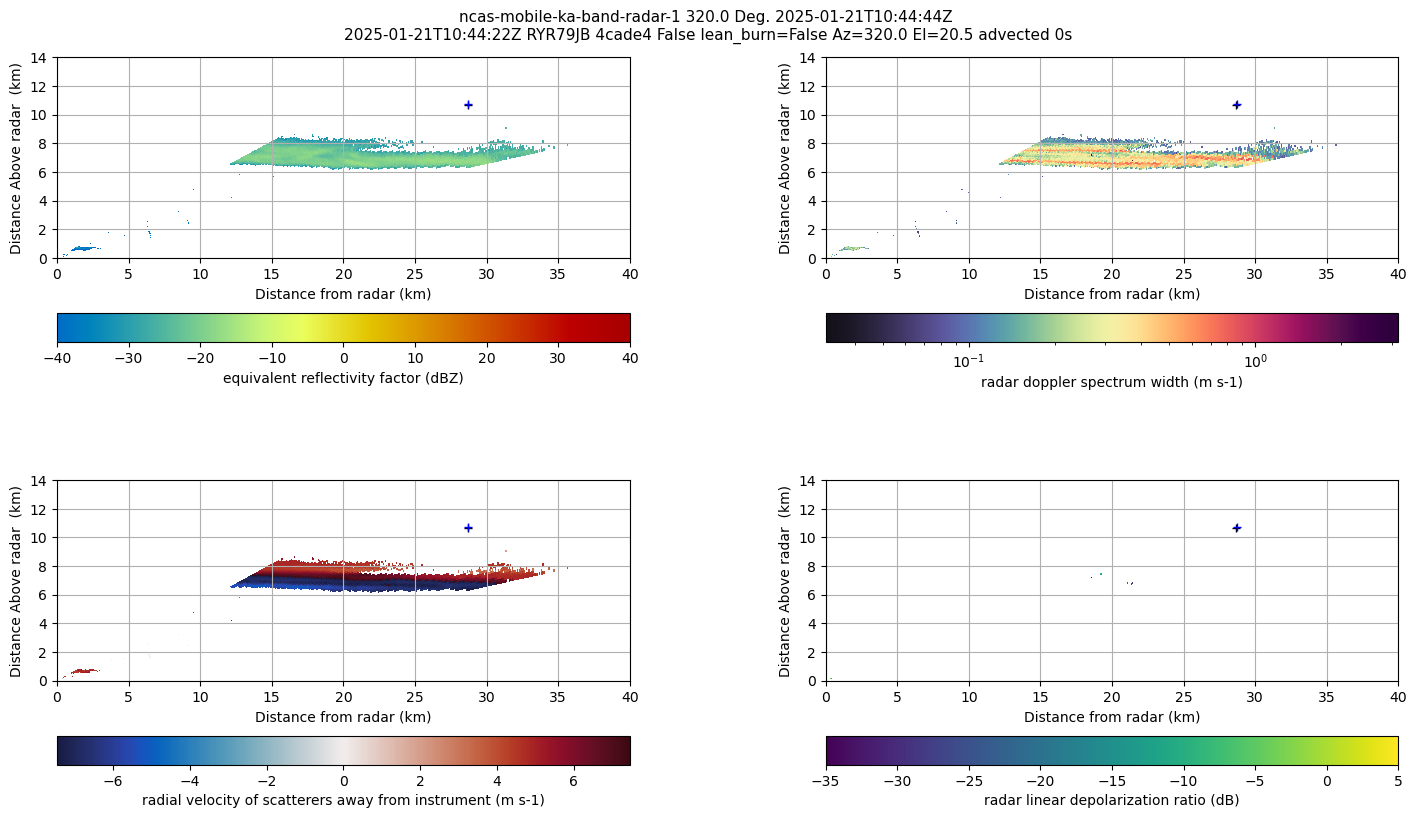

In [6]:
datestr = '20250121'
inpath_date = os.path.join(inpath,datestr);

os.chdir(inpath_date);
rhi_files = [os.path.join(inpath_date,f) for f in glob.glob('*{}*rhi*.nc'.format(datestr))]

selected_file = rhi_files[6];

Radar = pyart.io.read(selected_file);
Radar.info()

make_cobalt_rhi_plot(selected_file);

['/gws/nopw/j04/ncas_radar_vol2/cjw/projects/cobalt/L1/20250121/ncas-mobile-ka-band-radar-1_cao_20250121-000707_vpt_l1_v1.0.0.nc']
Sweeps within the time range: [79, 80, 81, 82, 83]
product version = v1.0.0


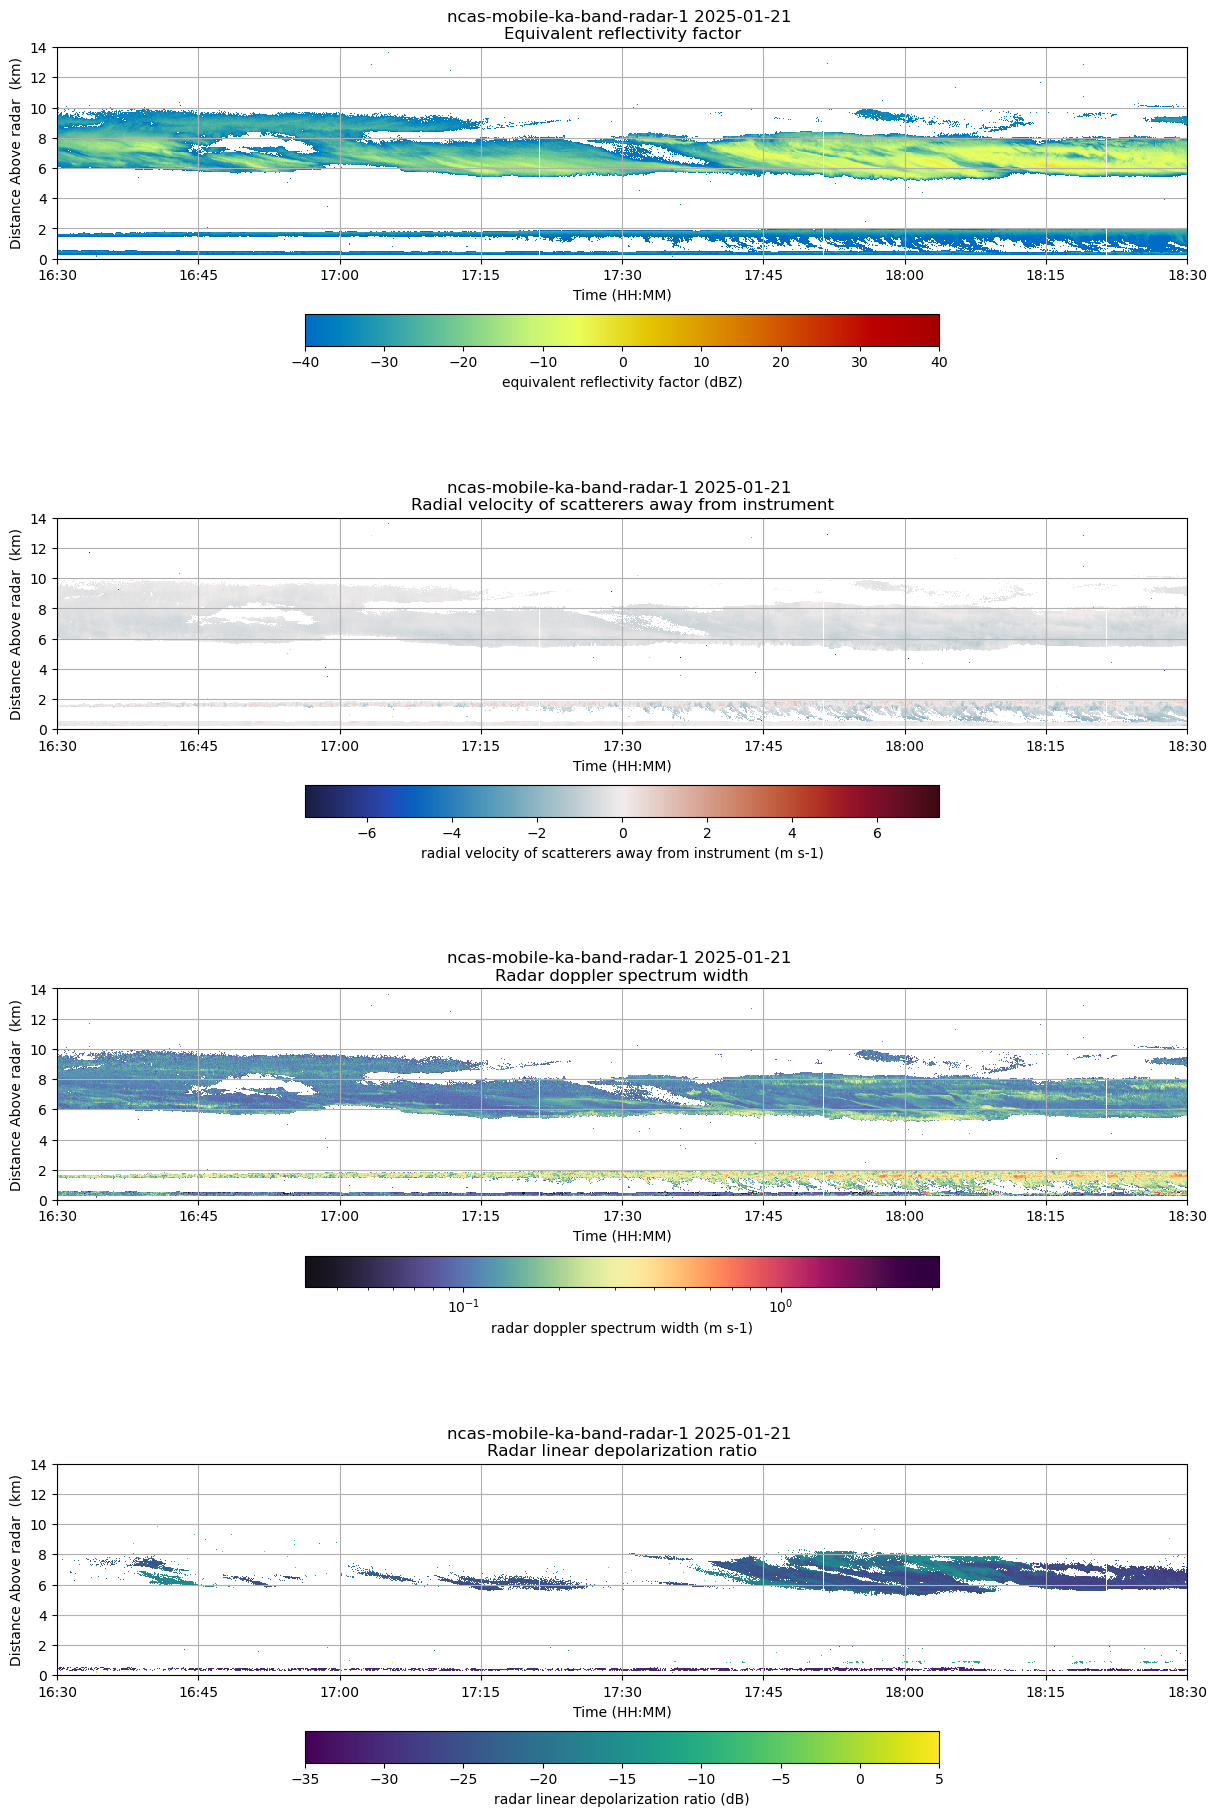

In [7]:
vpt_files = [os.path.join(inpath_date,f) for f in glob.glob('*{}*vpt*.nc'.format(datestr))]
print(vpt_files);
make_cobalt_vpt_plot(datestr,inpath,"16:30","18:30")